# Advanced Data Manipulation II: "I Love Group-By"

In this lecture, we'll work on some additional skills for manipulating and analyzing tabular data. Our focus will be on: 

- **Filtering** data, identifying specific rows according to complex criteria. 
- **Aggregating** data, computing complicated summaries of groups. 


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Takeaways for Today


1. The `transform()` and `apply()` methods can enable advanced computation on Pandas data frames using quite simple code. 
2. Pandas also offers specialized functions for common tasks, but getting the hang of `transform()` and `apply()` will take you far. 
3. Global warming is scary. 

Let's prepare the `countries` dataframe first.

In [2]:
countries_url = "https://raw.githubusercontent.com/mysociety/gaze/master/data/fips-10-4-to-iso-country-codes.csv"
countries = pd.read_csv(countries_url)
countries.head(5)

,FIPS 10-4,ISO 3166,Name
0,AF,AF,Afghanistan
1,AX,-,Akrotiri
2,AL,AL,Albania
3,AG,DZ,Algeria
4,AQ,AS,American Samoa


We also add metadata for each measurement stations at [this link](https://raw.githubusercontent.com/PIC16B-ucla/24F/refs/heads/main/datasets/noaa-ghcn/station-metadata.csv). The file contains station ID, latitude, longitude, station elevation, and station name.


In [3]:
url = "https://raw.githubusercontent.com/PIC16B-ucla/24F/refs/heads/main/datasets/noaa-ghcn/station-metadata.csv"
stations = pd.read_csv(url)
stations.head(5)

,ID,LATITUDE,LONGITUDE,STNELEV,NAME
0,ACW00011604,57.7667,11.8667,18.0,SAVE
1,AE000041196,25.3330,55.5170,34.0,SHARJAH_INTER_AIRP
2,AEM00041184,25.6170,55.9330,31.0,RAS_AL_KHAIMAH_INTE
3,AEM00041194,25.2550,55.3640,10.4,DUBAI_INTL
4,AEM00041216,24.4300,54.4700,3.0,ABU_DHABI_BATEEN_AIR


Today, we will work with all twelve csv files. The `prepare_df()` function basically summarizes what we did in the last lecture:

In [4]:
def prepare_df(df):
    """
    prepares a piece of wide format dataframe into a long format data frame
    """

    # melt to the long format table
    df = df.melt(
        id_vars = ["ID", "Year"],
        value_vars = [f"VALUE{i}" for i in range(1, 13)],
        var_name = "Month",
        value_name = "Temp"
    )

    # cleaning month and temp
    df["Month"] = df["Month"].str[5:].astype(int)
    df["Temp"]  = df["Temp"] / 100

    return df

The following code will download the csv files, process them, and concatenate them vertically.

<!--[f"{10*i+1}-{10*(i+1)}" for i in range(190, 202)]
pd.merge(df, stations, on="ID")-->

In [5]:
intervals = [f"{10 * i + 1}-{10 * (i+1)}" for i in range(190, 202)]

In [6]:
intervals

['1901-1910',
 '1911-1920',
 '1921-1930',
 '1931-1940',
 '1941-1950',
 '1951-1960',
 '1961-1970',
 '1971-1980',
 '1981-1990',
 '1991-2000',
 '2001-2010',
 '2011-2020']

In [8]:
%%time

intervals = [f"{10 * i + 1}-{10 * (i+1)}" for i in range(190, 202)]# quiz! 1901-1910 to 2011-2020.
dfs = []
for interval in intervals:
    url = f"https://raw.githubusercontent.com/PIC16B-ucla/24F/main/datasets/noaa-ghcn/decades/{interval}.csv"
    df = pd.read_csv(url)
    df = prepare_df(df)
    dfs.append(df)
df = pd.concat(dfs, axis=0, ignore_index=True)


CPU times: user 6.04 s, sys: 916 ms, total: 6.96 s
Wall time: 11.8 s


In [9]:
df.head()

,ID,Year,Month,Temp
0,AG000060390,1901,1,10.34
1,AG000060390,1902,1,9.84
2,AG000060390,1903,1,11.44
3,AG000060390,1904,1,9.26
4,AG000060390,1905,1,9.06


In [10]:
# add the country information
df["FIPS 10-4"] = df["ID"].str[:2]
df = pd.merge(df, countries, on="FIPS 10-4")
df = df.drop(["FIPS 10-4", "ISO 3166"], axis=1)

# add the station metadata
df = pd.merge(df, stations, on="ID")# how do we merge?

Let's check the memory usage of this dataframe:

In [11]:
df.memory_usage(index=True).sum()

1167059364

**POLL:** The number above is in bytes. Which of the following is the closest to this number?

- A. 100 MB
- B. 1 GB
- C. 10 GB
- D. 100 GB
- E. 1 TB

Let's filter them down, and select only the stations on the south of latitude -80 degrees, i.e., near the South Pole. Let's remove NaN values as well.

<!--df[df["LATITUDE"] < -80]
df[~np.isnan(df["Temp"])]-->

In [12]:
df = df[(df["LATITUDE"] < -80) & (~np.isnan(df["Temp"]))] # LATITUDE below -80, Temp not a NaN
df.head()

,ID,Year,Month,Temp,Name,LATITUDE,LONGITUDE,STNELEV,NAME
1017409,AYW00068201,1958,1,-14.52,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017410,AYW00068201,1959,1,-18.18,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017411,AYW00068201,1960,1,-15.96,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017412,AYW00068201,1957,2,-21.16,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017413,AYW00068201,1958,2,-14.94,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN


Split-apply-combine pattern

![image source: https://www.oreilly.com/api/v2/epubs/9781783985128/files/graphics/5128OS_09_01.jpg](https://www.oreilly.com/api/v2/epubs/9781783985128/files/graphics/5128OS_09_01.jpg)

_image source: https://www.oreilly.com/api/v2/epubs/9781783985128/files/graphics/5128OS_09_01.jpg_

## Grouped Summaries


We already know how to compute grouped summaries of the data using `pd.groupby().aggregate()`. For example, let's compute the mean temperature for each station within each month, averaged across years. Let's also compute the standard deviation and the number of observations. 
<!--
df.groupby(["NAME", "Month"])["Temp"].aggregate(["mean", "std", "count"]) 
-->

In [14]:
df.groupby(["NAME", "Month"])["Temp"].aggregate(["mean", "std", "count"])
# group by NAME (station name) and Month, compute mean, standard deviation, and counts for Temp.

mean       std  count
NAME           Month                            
AMUNDSEN_SCOTT 1     -27.900492  1.636293     61
               2     -40.524918  1.944692     61
               3     -53.653934  1.943314     61
               4     -57.389194  2.696554     62
               5     -57.731311  2.370763     61
...                         ...       ...    ...
THERESA        8     -29.309000  2.854964     20
               9     -28.089048  2.471694     21
               10    -23.256957  1.516552     23
               11    -16.888182  1.499434     22
               12    -11.063043  1.379418     23

[156 rows x 3 columns]

This is handy information, and it's convenient to be able to easily collect it in a summary table. However, there are some cases in which we may wish to compute new columns without creating a smaller summary table. Here's an example: 

## Temperature Anomaly Detection

Suppose we'd like to construct a list of unusually hot or cold months in our data set. For example, if February in 1995 is much warmer than average, we'd like to detect this. What makes a month "unusually hot or cold"? There are lots of valid ways to define this. How would you approach this? 

<br> <br> <br> <br> <br> 

For our first attempt, let's ask the following idea: 

> For each temperature reading, how does that reading compare to the average reading *in that month* and *at that measurement station*?

For example, if July in 2017 at Amundsen-Scott station was much warmer than the average July reading at that station, then we might say that July 2017 was anomalous. 

### Z-Scores

To make this concrete, let's say that a given month in a year is anomalous if it is more than two standard deviations away from the mean for that month. If you've taken a statistics class, this is the same as requiring that the *z-score* for that month is larger than 2 in absolute value. That is, we should compute:

$$
z = \frac{\text{reading} - \text{average reading at station in month}}{\text{standard deviation at station in month}}
$$

and ask whether $|z| > 2$. 

How to compute this? Well, we already know how to compute means and standard deviations using methods like our table above, but it's hard to make comparisons to individual months this way. Can you think of how you would perform such a computation in Python? 

<br> <br> <br> <br> <br> 

If you suggested that we `merge` the summary table from above to our original `df`, that would eventually work! But `merge` is a slow operation, and we can actually avoid it by using what are sometimes called *window functions.* A window function operates on grouped data, **without reducing the length of the data frame.** In `pandas`, the most general way to create window functions is by using the `transform()` method of data frames and series. For example: 

In [15]:
df

,ID,Year,Month,Temp,Name,LATITUDE,LONGITUDE,STNELEV,NAME
1017409,AYW00068201,1958,1,-14.52,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017410,AYW00068201,1959,1,-18.18,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017411,AYW00068201,1960,1,-15.96,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017412,AYW00068201,1957,2,-21.16,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
1017413,AYW00068201,1958,2,-14.94,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN
...,...,...,...,...,...,...,...,...,...
1042807,AYM00089013,2016,12,-17.65,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS
1042808,AYM00089013,2017,12,-18.75,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS
1042809,AYM00089013,2018,12,-17.00,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS
1042810,AYM00089013,2019,12,-16.80,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS


To compute the average temperature in each month for each station...(notice the length of the result!)

In [16]:
df.groupby(["NAME", "Month"])["Temp"].transform("mean")

1017409   -15.102500
1017410   -15.102500
1017411   -15.102500
1017412   -20.073846
1017413   -20.073846
             ...    
1042807   -18.690000
1042808   -18.690000
1042809   -18.690000
1042810   -18.690000
1042811   -18.690000
Name: Temp, Length: 3642, dtype: float64

Compare this to:

In [17]:
#note the length!
df.groupby(["NAME", "Month"])["Temp"].aggregate("mean")

NAME            Month
AMUNDSEN_SCOTT  1       -27.900492
                2       -40.524918
                3       -53.653934
                4       -57.389194
                5       -57.731311
                           ...    
THERESA         8       -29.309000
                9       -28.089048
                10      -23.256957
                11      -16.888182
                12      -11.063043
Name: Temp, Length: 156, dtype: float64

In [18]:
r = df.groupby(["NAME", "Month"])["Temp"].aggregate("mean")
r.BALDRICK_AWS

Month
1    -19.718333
2    -28.950833
3    -39.696667
4    -43.322500
5    -45.956667
6    -46.141667
7    -49.264545
8    -49.092727
9    -47.711000
10   -40.610000
11   -27.379167
12   -18.690000
Name: Temp, dtype: float64

Because the length of the output of `transform` is the same as that of the original data, we can use `transform` to create new columns. Here's a simple function to compute z-scores of an array: 

In [19]:
def z_score(x):
    m = np.mean(x)
    s = np.std(x)
    return (x - m)/s

Now we can compute the z-scores in one shot: 

<!--df.groupby(["NAME", "Month"])["Temp"].transform(z_score)-->

In [20]:
df["z"] = df.groupby(["NAME", "Month"])["Temp"].transform(z_score)

In [21]:
df["z"]

1017409    0.254325
1017410   -1.343665
1017411   -0.374392
1017412   -0.365240
1017413    1.726353
             ...   
1042807    0.890337
1042808   -0.051366
1042809    1.446798
1042810    1.618017
1042811   -0.094170
Name: z, Length: 3642, dtype: float64

Using `transform`, we can skip both computing the summary table and merging it later. We're now ready to find anomalous months in our data. Before we do, we're going to add a handy column to the original data for plotting purposes. We already saw this code in a prior lecture. 

In [22]:
df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str))

Ok, now let's get a subset data frame with the temperature anomalies -- rows with absolute value of z score greater than 2: 

<!--df[np.abs(df["z"]) > 2]-->

In [23]:
anomalies = df[np.abs(df["z"]) > 2]# FILL IN

In [24]:
anomalies

,ID,Year,Month,Temp,Name,LATITUDE,LONGITUDE,STNELEV,NAME,z,Date
1017436,AYW00068201,1957,8,-28.85,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,2.054886,1957-08-01
1017546,AYW00068201,1961,10,-37.33,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-2.079699,1961-10-01
1017632,AYW00068201,1972,12,-24.65,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-3.045256,1972-12-01
1017721,AYW00068201,1986,11,-27.02,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-2.566955,1986-11-01
1018205,AYW00090001,1958,2,-35.26,Antarctica,-90.0000,0.0000,9999.0,AMUNDSEN_SCOTT,2.729796,1958-02-01
...,...,...,...,...,...,...,...,...,...,...,...
1042727,AYM00089013,2016,4,-37.75,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,2.225897,2016-04-01
1042739,AYM00089013,2018,5,-38.70,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,2.045127,2018-05-01
1042744,AYM00089013,2013,6,-37.64,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,2.234982,2013-06-01
1042753,AYM00089013,2012,7,-54.15,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,-2.205300,2012-07-01


We can now, for example, plot these anomalies for a given station: 

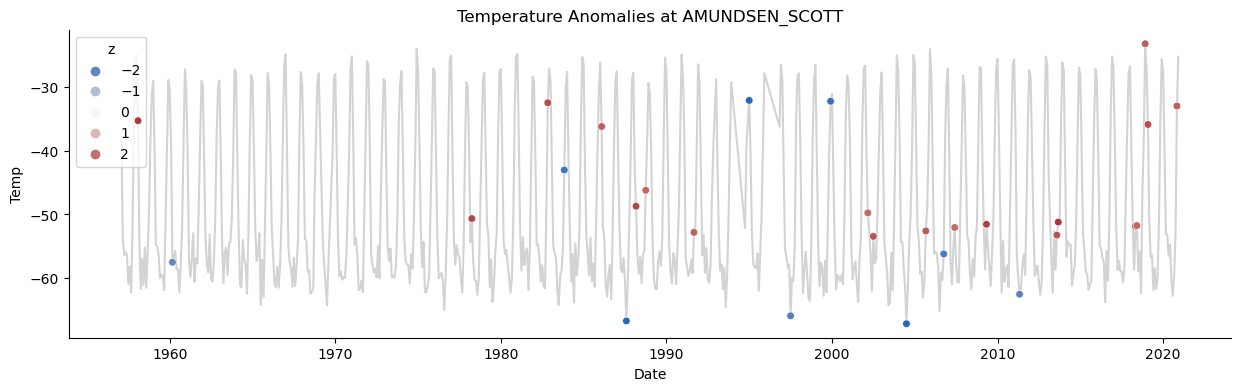

In [25]:
station = "AMUNDSEN_SCOTT"

import seaborn as sns

fig = plt.subplots(figsize = (15, 4))

sns.lineplot(data = df[df["NAME"] == station], 
             x = "Date", 
             y = "Temp",
             color = "lightgrey")

sns.scatterplot(data = anomalies[anomalies["NAME"] == station], 
                x = "Date", 
                y = "Temp", 
                zorder = 100, # show the dots on top
                hue = "z",
                s = 30, # marker size
                palette = "vlag")

plt.gca().set(title = f"Temperature Anomalies at {station}") #gca: "get current axis"
sns.despine() # remove top and right spine

It looks like the rate of anomalies is increasing with time -- yikes. Predictably, most of the anomalies are anomalously *warm*. 



### Max and Min

That approach works fine, but suppose now that we'd like to try things a different approach: we want to compute the warmest and coldest instances of each month on record. For example, we'd like to answer questions like: 

> *In what year did Amundsen-Scott Station record the warmest February, on average?* 

One approach to this is to obtain rankings on individual subsets:

In [26]:
df

,ID,Year,Month,Temp,Name,LATITUDE,LONGITUDE,STNELEV,NAME,z,Date
1017409,AYW00068201,1958,1,-14.52,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,0.254325,1958-01-01
1017410,AYW00068201,1959,1,-18.18,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-1.343665,1959-01-01
1017411,AYW00068201,1960,1,-15.96,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-0.374392,1960-01-01
1017412,AYW00068201,1957,2,-21.16,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-0.365240,1957-02-01
1017413,AYW00068201,1958,2,-14.94,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,1.726353,1958-02-01
...,...,...,...,...,...,...,...,...,...,...,...
1042807,AYM00089013,2016,12,-17.65,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,0.890337,2016-12-01
1042808,AYM00089013,2017,12,-18.75,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,-0.051366,2017-12-01
1042809,AYM00089013,2018,12,-17.00,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,1.446798,2018-12-01
1042810,AYM00089013,2019,12,-16.80,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,1.618017,2019-12-01


In [27]:
df["rank"] = df.groupby(["NAME", "Month"])["Temp"].rank()

In [28]:
df["rank"]

1017409    12.0
1017410     3.0
1017411     6.0
1017412     6.0
1017413    13.0
           ... 
1042807     9.0
1042808     8.0
1042809    11.0
1042810    12.0
1042811     7.0
Name: rank, Length: 3642, dtype: float64

In [29]:
np.isnan(df["rank"]).sum()

0

In [30]:
df["rank"] = df.groupby(["NAME", "Month"])["Temp"].rank().astype(int)

In [31]:
# coldest month in record
coldest = df[df["rank"] == 1]
coldest

,ID,Year,Month,Temp,Name,LATITUDE,LONGITUDE,STNELEV,NAME,z,Date,rank
1017415,AYW00068201,1960,2,-24.40,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-1.454751,1960-02-01,1
1017419,AYW00068201,1960,3,-31.83,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-1.622580,1960-03-01,1
1017433,AYW00068201,1958,7,-40.74,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-1.455634,1958-07-01,1
1017437,AYW00068201,1958,8,-42.22,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-1.434706,1958-08-01,1
1017487,AYW00068201,1962,4,-36.46,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,-1.656489,1962-04-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1042714,AYM00089013,2013,3,-44.30,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,-2.043541,2013-03-01,1
1042728,AYM00089013,2017,4,-47.20,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,-1.548841,2017-04-01,1
1042733,AYM00089013,2012,5,-51.70,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,-1.618628,2012-05-01,1
1042753,AYM00089013,2012,7,-54.15,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,-2.205300,2012-07-01,1


There's a bit of a sticky point here: it's easy to get the *coldest* months on record this way, because they all have the same rank (1). However, getting the *warmest* months is a little trickier, because they have different ranks (due to some stations not having data in all years or months): 

In [32]:
df.groupby(["NAME", "Month"])["rank"].agg("count")

NAME            Month
AMUNDSEN_SCOTT  1        61
                2        61
                3        61
                4        62
                5        61
                         ..
THERESA         8        20
                9        21
                10       23
                11       22
                12       23
Name: rank, Length: 156, dtype: int64

How can we extract the warmest months? We can use `transform()`! 

In [33]:
df["len"] = df.groupby(["NAME", "Month"])["rank"].transform("count")

In [34]:
warmest = df[df["rank"] == df["len"]]
warmest

,ID,Year,Month,Temp,Name,LATITUDE,LONGITUDE,STNELEV,NAME,z,Date,rank,len
1017413,AYW00068201,1958,2,-14.94,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,1.726353,1958-02-01,13,13
1017422,AYW00068201,1959,4,-23.92,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,1.618718,1959-04-01,13,13
1017436,AYW00068201,1957,8,-28.85,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,2.054886,1957-08-01,13,13
1017440,AYW00068201,1957,9,-30.67,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,1.601624,1957-09-01,13,13
1017444,AYW00068201,1957,10,-26.11,Antarctica,-80.0167,-119.5333,1543.2,BYRD_STN,1.607040,1957-10-01,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042769,AYM00089013,2018,8,-45.90,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,1.384187,2018-08-01,11,11
1042774,AYM00089013,2013,9,-42.40,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,2.233290,2013-09-01,10,10
1042786,AYM00089013,2015,10,-37.20,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,1.604835,2015-10-01,12,12
1042801,AYM00089013,2020,11,-25.30,Antarctica,-82.7670,-13.0500,1968.0,BALDRICK_AWS,1.399557,2020-11-01,12,12


## Other Approaches

Many tasks in `pandas` can be performed in more than one way. In this lecture so far, I've focused on the `transform` method of grouped data frames, which is extraordinarily flexible and can be used for many purposes. However, there are also specialized methods that you may wish to research on your own time. For example, Pandas offers a [dedicated method for applying more general functions](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.pipe.html), as well as a [dedicated filtering](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.filter.html) method. If you find yourself needing to perform many ranking or filtering operations, learning these methods may be a good use of your time. 

# Custom Aggregation

Earlier in this lecture, we reviewed an example of how to compute aggregates like means and standard deviations using `aggregate`. Here it is again: 

In [35]:
df.groupby(["NAME", "Month"])["Temp"].agg(["mean", "std", "count"])
# agg is just an alias of aggregate.

mean       std  count
NAME           Month                            
AMUNDSEN_SCOTT 1     -27.900492  1.636293     61
               2     -40.524918  1.944692     61
               3     -53.653934  1.943314     61
               4     -57.389194  2.696554     62
               5     -57.731311  2.370763     61
...                         ...       ...    ...
THERESA        8     -29.309000  2.854964     20
               9     -28.089048  2.471694     21
               10    -23.256957  1.516552     23
               11    -16.888182  1.499434     22
               12    -11.063043  1.379418     23

[156 rows x 3 columns]

That's fun, but we can also compute *custom aggregates* using any function we want that takes in a series of numbers and spits out a new number. This is a very powerful ability, especially if you try get a little creative with it! The `apply` method is usually the way to go. For example, let's compute a simple estimate of the **year-over-year average change in temperature** in each month at each station. For this, we'll use our old friend, linear regression. We'll use the statistical fact that, when regressing `Temp` against `Year`, the coefficient of `Year` will be an estimate of the yearly change in `Temp`. 

In [36]:
from sklearn.linear_model import LinearRegression

def coef(data_group):
    x = data_group[["Year"]] # 2 brackets because X should be a df
    y = data_group["Temp"]   # 1 bracket because y should be a series
    LR = LinearRegression()
    LR.fit(x, y)
    return LR.coef_[0]

Although this might look a bit strange as a function for using `apply` (wasn't this from the machine learning part of the class?), it's a perfectly good way to compute data summaries, as it takes in two data columns and spits out a number. 

<!--df.groupby(["NAME", "Month"]).apply(coef)-->

In [37]:
coefs = df.groupby(["NAME", "Month"]).apply(coef)# FILL IN

coefs = coefs.reset_index()
coefs

,NAME,Month,0
0,AMUNDSEN_SCOTT,1,0.009775
1,AMUNDSEN_SCOTT,2,-0.006219
2,AMUNDSEN_SCOTT,3,0.021752
3,AMUNDSEN_SCOTT,4,0.004177
4,AMUNDSEN_SCOTT,5,0.005560
...,...,...,...
151,THERESA,8,0.156196
152,THERESA,9,-0.020949
153,THERESA,10,0.031716
154,THERESA,11,0.035552


At what proportion of station/months is the temperature rising? 

In [38]:
(coefs[0] > 0).mean()# uh oh

0.6025641025641025

**POLL**: (Multiple choice) Which of the following is NOT correct about `apply()`?
- A. `apply()` is more flexible and general compared to `agg()`.
- B. `apply()` is generally slower for aggration operations than `agg()`.
- C. `apply()` only operates on a single column. For multiple columns, the functions are applied to each column separately.
- D. `apply()` function can implement what `agg()` and `transform()` does.

### Takeaways for Today

1. The `transform()` and `apply()` methods can enable advanced computation using simple code. 
2. Pandas also offers specialized functions for common tasks, but getting the hang of `transform()` and `apply()` will take you far. 
3. Global warming is scary. 

Sometimes, data wrangling can have a lot of steps. One example data wrangling pipeline for intensive care electronic health record dataset: 


```python
chartevents_df_1ststay = (
    chartevents_df.
    merge(
        icustays_df_1ststay[["stay_id", "intime", "outtime"]],
        how = "right",
        on = "stay_id"). # 15738363 rows
    query("charttime >= intime and charttime <= outtime"). # 15700234 rows
    sort_values(["stay_id", "itemid", "charttime"]).
    groupby(["stay_id", "itemid"]).
    head(1). # 263332 rows
    drop(["charttime", "intime", "outtime"], axis="columns"). # remove unnecessary columns
    astype({"itemid": str}). # change it to string for easier renaming
    pivot(index="stay_id", columns="itemid", values="valuenum").
    rename(columns={"220045.0": "heart_rate",
            "223761.0": "temp_f"})
)
```
https://github.com/LangeSymposium/2022-July-Workshop

If you learn data wrangling with other languages, it is common to use the pipe operator to write the operations in actual operation sequence. However, since Python is OOP, we can just chain the methods in many cases. When pipe is needed for readability? There is a dedicated `pipe()` method.

```
h(g(f(df))) # to make this more readable...
f(df) | g | h # people write this way using the pipe operator (`|` here, just as an example) in other languages. 
```
We don't need to do it in Python.
